<a href="https://colab.research.google.com/github/Bhargavi1504/Regression-algorithms/blob/main/elasticnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#1.data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder
import random

np.random.seed(42)
n_samples=1000

missing_fraction = 0.1
duplicate_fraction = 0.05
outlier_fraction = 0.03

#functions
def random_generator_cat(choices,n):
  return np.random.choice(choices,n)

def generate_dates(n):
  base = datetime.today()
  return [base - timedelta(days=random.randint(0,2000)) for _ in range(n_samples)]

#raw features
Age = np.random.randint(5,80,n_samples)
experience=np.clip(Age - np.random.randint(18,25,n_samples),0,None)
education= random_generator_cat(['Bachelors','Masters','PHD'],n_samples)
city = random_generator_cat(['New York', 'San Francisco', 'Chicago', 'Austin'],n_samples)
job_role = random_generator_cat(['Data Scientist','Data Analyst','Data Engineer'],n_samples)
gender = random_generator_cat(['Male', 'Female', 'Other'], n_samples)
join_date = generate_dates(n_samples)
performance = np.random.normal(70,10,n_samples).round(2)
working_hours= np.random.normal(40,5,n_samples).round(1)
married = np.random.choice([0, 1], n_samples)
social_activity = np.random.normal(2, 1, n_samples).round(1)

# Multicollinear & noisy features
salary=experience * 3000 + Age* 200 + np.random.normal(0,1000,n_samples)
loan_amount = salary * 0.3 + np.random.normal(0,5000,n_samples)
spending_score= np.random.normal(50,20,n_samples).round(1)
rating = np.random.randint(1, 6, n_samples)
target_salary = salary * 1.1 + np.random.normal(0, 3000, n_samples)
will_churn = np.random.choice([0, 1], n_samples, p=[0.7, 0.3])


# 4. Create DataFrame
d=pd.DataFrame({
    'Age': Age,
    'salary': salary.round(2),
    'experience': experience,
    'education_level': education,
    'city': city,
    'job_role': job_role,
    'gender': gender,
    'join_date': join_date,
    'performance': performance,
    'working_hours': working_hours,
    'married': married,
    'loan_amount': loan_amount.round(2),
    'spending_score': spending_score,
    'rating': rating,
    'social_activity': social_activity,
    'target_salary': target_salary.round(2),
    'will_churn': will_churn
})

# Inject Missing Values
for i in d.columns:
  d.loc[d.sample(frac = missing_fraction).index,i]=np.nan

# Inject Duplicates
num_duplicates = int(n_samples * duplicate_fraction )
duplicate_rows = d.sample(num_duplicates)
d=pd.concat([d,duplicate_rows],ignore_index=True)

# Inject Outliers
def inject_outliers(d,column,fraction = outlier_fraction,factor=10):
    num_outliers = int(len(d)* fraction)
    indices = np.random.choice(d.index,num_outliers,replace=True)
    d.loc[indices,column] *= factor

inject_outliers(d, 'salary')
inject_outliers(d, 'loan_amount')

# Encode Categorical for ML
d_encoded=d.copy()
label_cols= ['education_level', 'city', 'job_role', 'gender']
encoders={}
for c in label_cols:
  le=LabelEncoder()
  d_encoded[c] = d_encoded[c].astype(str) #avoid NaNs
  d_encoded[c]=le.fit_transform(d_encoded[c])
  encoders[c]= le

# 9. Export
# -------------------------------
d.to_csv("dirty_dataset.csv", index=False)
d_encoded.to_csv("dirty_dataset_encoded.csv", index=False)

print("✅ Dirty dataset and encoded version saved!")


✅ Dirty dataset and encoded version saved!


In [2]:
import pandas as pd

de = pd.read_csv("dirty_dataset_encoded.csv")
print("Original Dirty Shape:", de.shape)



Original Dirty Shape: (1050, 17)


In [4]:
#missing value
from sklearn.impute import SimpleImputer

de = de.dropna(subset=['target_salary'])

num_cols = de.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='median')
de[num_cols] = imputer.fit_transform(de[num_cols])


In [5]:
#outliers
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    mask = (data[column] >= Q1 - 1.5 * IQR) & (data[column] <= Q3 + 1.5 * IQR)
    return data[mask]

for col in ['target_salary', 'salary', 'loan_amount']:
    de = remove_outliers_iqr(de, col)

print("Shape after outlier removal:", de.shape)


Shape after outlier removal: (915, 17)


In [6]:
from sklearn.preprocessing import StandardScaler

X = de.drop(columns=['target_salary', 'will_churn', 'join_date'])
y = de['target_salary']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [7]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=42)

In [8]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

# Mix of Lasso (l1_ratio = 1.0) and Ridge (l1_ratio = 0.0)
elastic = ElasticNet(alpha=10, l1_ratio=0.5)  # 0.5 = 50% L1 + 50% L2
elastic.fit(x_train, y_train)

y_pred = elastic.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📉 RMSE:", round(rmse, 2))
print("📈 R² Score:", round(r2, 4))


📉 RMSE: 40222.05
📈 R² Score: 0.6378


In [11]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9]
}

model = ElasticNet()
grid = GridSearchCV(model, param_grid, cv=5, scoring='r2')
grid.fit(x_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(x_test)


In [12]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📉 RMSE:", round(rmse, 2))
print("📈 R² Score:", round(r2, 4))

📉 RMSE: 14768.41
📈 R² Score: 0.9512


In [13]:
#Coefficient Analysis
import numpy as np
import pandas as pd

coefs = pd.Series(elastic.coef_, index=X.columns)

print("🔍 Non-zero Coefficients:")
print(coefs[coefs != 0].sort_values(ascending=False))

print("\n❌ Zeroed Coefficients:")
print(coefs[coefs == 0].index.tolist())


🔍 Non-zero Coefficients:
experience         7709.018437
Age                7498.732452
salary             7388.663259
loan_amount        6998.268371
social_activity      95.769754
performance          69.821802
education_level      69.228347
spending_score      -14.037149
working_hours       -37.772943
job_role            -84.106284
married             -98.727565
city               -143.649784
rating             -246.070201
gender             -276.233478
dtype: float64

❌ Zeroed Coefficients:
[]


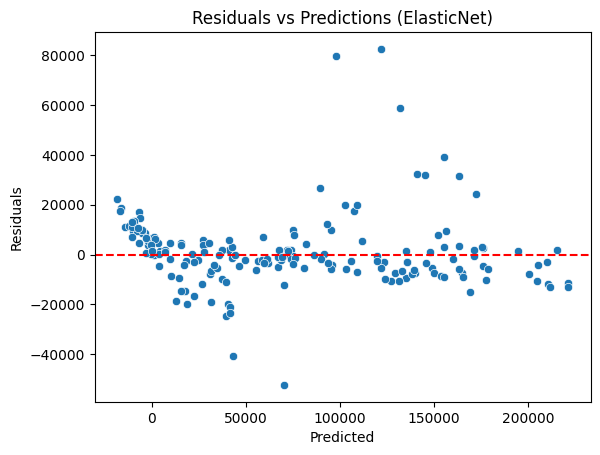

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

residuals = y_test- y_pred

sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predictions (ElasticNet)")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()


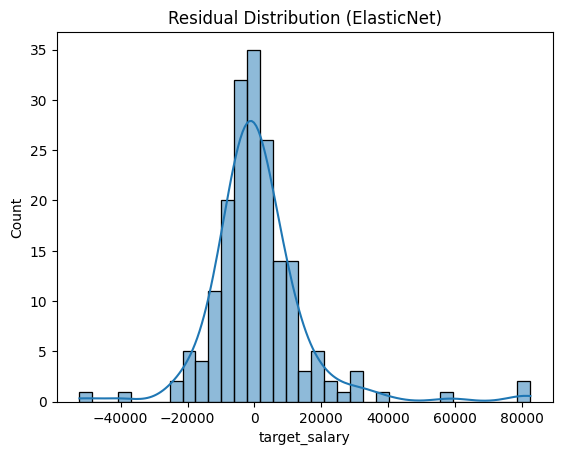

In [15]:
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution (ElasticNet)")
plt.show()


/tmp/ipython-input-20-349939670.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_train_de, plot_type="bar")


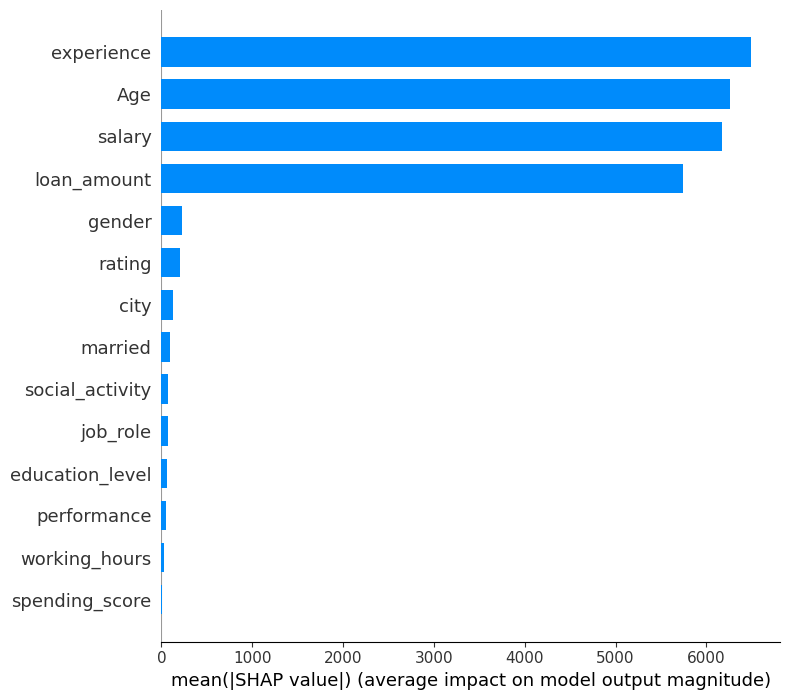

In [20]:
# Step 6: SHAP Explainability
import shap

features = X.columns
x_train_de = pd.DataFrame(X_scaled, columns=features)

explainer = shap.Explainer(elastic, x_train_de)
shap_values = explainer(x_train_de)

shap.summary_plot(shap_values, x_train_de, plot_type="bar")




